In [1]:
import pandas as pd
import numpy as np
import math
import glob
import datetime
import time

## Вроде бы, всё свелось к тому, что нужно задать путь к файлам и папку, куда сохранить, откинуться на спинку кресла и ждать выполнения самой последней ячейки блокнота

In [5]:
"""
Подготовка списка датафреймов по соответствующим постам
И списка ID выбранных постов

"""

path = '/mnt/SSD/education/aspirantura/CAMELS_ru/files/hydrology/2020-09-22_15-39'
path_to_results = '/mnt/SSD/education/aspirantura/CAMELS_ru/code/camels_ru/results/'

In [ ]:
"""
Store Lat, Lon values as tuple with same
position as index of station
            
"""

GRDC_Stations = pd.read_excel(path + '/GRDC_Stations.xlsx')
Valid_lat_lon = list()
for j in range(len(Valid_WS)):
    for i in range(len(temporary)):    
        if Valid_WS.ID.loc[j] == temporary.grdc_no.loc[i]:
            Valid_lat_lon.append((temporary.lat.loc[i], temporary.long.loc[i]))

#### Функция по пути и фомату файла суточных данных с GRDC 
#### создаёт каталоги индексов гидрологических постов
#### и создаёт каталог файлов не пустых постов в соответствии с их индексом

In [6]:
def read_data(path):
    all_files = glob.glob(path + '/*_Q_Day.Cmd.txt')
    list_of_gauges = list()
    list_of_station_IDS = [i[74:81] for i in all_files] # лист всех ID из представленных постов
    valid_IDS = list()
    for i, gauge in enumerate(all_files):

        """
        skip instance if it's empty

        """
        test = pd.read_csv(gauge, skiprows = 36, delimiter = ';', skipinitialspace = True)

        if test.empty:
            pass

        else:
            """
            read data; 
            change default column names;
            replace -999 with NaN;
            drop unnecessary column;
            add column with baseflow calculated with BFI function
            add it to list of valid time serieses 

            """
            test.Value = test.Value.replace(-999, np.NaN)
            test['YYYY-MM-DD'] = pd.to_datetime(test['YYYY-MM-DD'])
            test = test.drop(columns = ['hh:mm'])
            test.rename(columns = {'YYYY-MM-DD': 'Date', 'Value': 'Q'}, inplace = True)
            test['Qbase'] = np.NaN
            list_of_gauges.append(test)
            valid_IDS.append(int(list_of_station_IDS[i]))
    print('количество постов с убранными пустышками {}, всего постов с суточными данными {}'.format(len(list_of_gauges), len(all_files)))
    return valid_IDS, list_of_gauges
    

In [7]:
valid_IDS, list_of_gauges = read_data(path)


количество постов с убранными пустышками 211, всего постов с суточными данными 1491


#### Функции считывает geojson файл с GRDC 
#### и возвращает список площадей водосборов 
#### в соответсвии с индексом поста из "не пустых" постов

In [8]:
def get_WS_info(path, valid_IDS):
    import geojson as gjs
    with open(path + '/stationbasins.geojson') as f:
        WS_info = gjs.load(f)

    WS_info = [i['attributes'] for i in WS_info['features']]

    Valid_WS_Info = [WS_info[i] for i in range(len(WS_info)) if WS_info[i]['grdc_no'] in valid_IDS]
    
    Valid_WS = pd.DataFrame(columns = {'ID', 'River_Name', 'WS_area'}) # dataframe for WS data
    Valid_WS.ID = valid_IDS # assign only valuable WS with daily discharge available

    temp_list_for_AREA = [[] for _ in range(len(Valid_WS.ID))] # empty list to store river name
    # list of lists is used as a solution to solve .loc copy problem from df
    temp_list_for_RIVER_NAME = [[] for _ in range(len(Valid_WS.ID))]

    for j in range(len(Valid_WS.ID)):
        for i in range(len(Valid_WS_Info)):
            fnd = True
            while fnd:

                fnd = False

                if Valid_WS.ID.loc[j] == Valid_WS_Info[i]['grdc_no']:
                    temp_list_for_AREA[j].append(Valid_WS_Info[i]['area_hys'])
                    temp_list_for_RIVER_NAME[j].append(Valid_WS_Info[i]['river'] + ' - ' + Valid_WS_Info[i]['station'])

                    fnd = True
                    break

    temp_list_for_AREA = [np.NaN if len(i) == 0 else i[0] for i in temp_list_for_AREA]
    temp_list_for_RIVER_NAME = [np.NaN if len(i) == 0 else i[0] for i in temp_list_for_RIVER_NAME]

    """
    Датасет сформирован таким образом, что здесь используются только те посты, 
    по которым есть данные суточного стока
    Расположены они в том же порядке, что и данные по расходам в
    переменной

    Далее, обращаясь к ID, получаем данные по площади водосбора,
    которые используются дальше, при получении миллиметров слоя

    """

    Valid_WS.River_Name = temp_list_for_RIVER_NAME
    Valid_WS.WS_area = temp_list_for_AREA
    Valid_WS = Valid_WS[[Valid_WS.columns.tolist()[1], Valid_WS.columns.tolist()[2], Valid_WS.columns.tolist()[0]]]
    
    return Valid_WS
Valid_WS = get_WS_info(path, valid_IDS)

In [9]:
Valid_WS = get_WS_info(path, valid_IDS)

#### Функция фильтрует файл и оставляет данные только 
#### по тем водосборам, у которых имеется информация о площади.
#### Для оставшихся постов рассчитывается значение слоя стока

In [11]:
def get_WS_w_Area(Valid_WS):
    """
    Дальнейший расчёт будет вестись только для тех постов,
    у которых есть данные о площади

    """
    Valid_WS = Valid_WS.dropna().reset_index(drop = True)
    Valid_gauges_Q_cms = [gauge for i, gauge in enumerate(list_of_gauges) if valid_IDS[i] in Valid_WS.ID.to_numpy()]

    import copy

    Valid_gauges_Q_mm = copy.deepcopy(Valid_gauges_Q_cms)

    """
    calculate layer of discharge

    """

    for i, gauge in enumerate(Valid_gauges_Q_mm):
        gauge.Q = 86400 * gauge.Q * 10**9 / (Valid_WS.WS_area.loc[i] * 10**12)
    print('количество постов с данными и площадью {}, всего постов с суточными данными {}'.format(len(Valid_gauges_Q_mm), len(valid_IDS)))
    return Valid_gauges_Q_mm, Valid_gauges_Q_cms
Valid_gauges_Q_mm, Valid_gauges_Q_cms = get_WS_w_Area(Valid_WS)

In [12]:
Valid_gauges_Q_mm, Valid_gauges_Q_cms = get_WS_w_Area(Valid_WS)


количество постов с данными и площадью 186, всего постов с суточными данными 211


#### Функция разбивает непрерывный ряд наблюдений на отдельные года, с учётом количества NaN в году
#### На вход подаётся лист датафреймов с двумя необходимыми столбцами:
#### Date - где будет записана дата в формате datetime
#### Q - где будет записано значение расхода
#### Возвращается лист датафреймов отдельных лет, из которых выкинуты те, где количество NaN превысило лимит

In [13]:
def split_by_year(list_of_something, number_of_NaN):
    
    """
    Данная функция разбивает лист датафреймов по годам
    и выкидывает года, где NaN регулируется переменной number_of_NaN
    
    Колонка Date в датафрейме внутри листа - даты
    и она обязательна. 
    Столбцы могут называться в соответствии с пожеланиями
    
    """
    splitted_list = list()

    for i, gauge in enumerate(list_of_something):
        """
        From list of lists we are calling another list 
        that consist list of dataframes

        """
        year_split = list()
        unique_years = gauge.Date.dt.year.unique()

        for year in unique_years:
            year_split.append(gauge[gauge.Date.dt.year == year].reset_index(drop = True))

        for i in range(len(year_split)-1, -1, -1):
            if sum(year_split[i].Q.isna()) > number_of_NaN:
                del year_split[i]
            else:
                pass

        splitted_list.append(year_split)
    
    return splitted_list

### q_mean

In [14]:
def mean_for_gauge(list_of_gauges):
    gauges_Q_mean = [np.nanmean(i.Q) for i in list_of_gauges]
    return gauges_Q_mean
"""
Q mean for observations on every valid gauge. Dimension - mm/day

"""
Valid_gauges_Q_mean = mean_for_gauge(Valid_gauges_Q_mm)

In [15]:
"""
Q mean for observations on every valid gauge. Dimension - mm/day

"""
Valid_gauges_Q_mean = mean_for_gauge(Valid_gauges_Q_mm)
print('количество постов с рассчитанным средним {}, всего постов с суточными данными {}'.format(
    len(np.array(Valid_gauges_Q_mean)[~np.isnan(Valid_gauges_Q_mean)]),
    len(Valid_gauges_Q_mean)))

количество постов с рассчитанным средним 186, всего постов с суточными данными 186


In [11]:
CAMELS_Addor = pd.read_csv('/mnt/SSD/education/aspirantura/CAMELS_ru/literature/camels_attributes_v2.0/camels_hydro.txt', sep = ';')

In [12]:
CAMELS_Addor

,gauge_id,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean
0,1013500,1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,6.10,8.714286,41.35,20.170732,0.000000,207.25
1,1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.000000,166.25
2,1030500,1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,12.25,7.205882,89.25,19.402174,0.000000,184.90
3,1031500,2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,18.90,3.286957,94.80,14.697674,0.000000,181.00
4,1047000,2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,14.95,2.577586,71.55,12.776786,0.000000,184.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,14309500,2.457700,0.493734,1.689890,0.459455,1.220096,0.057651,10.203129,41.10,4.835294,165.55,41.911392,0.000000,125.55
667,14316700,2.925937,0.643997,2.231023,0.508616,1.552484,0.141493,10.653569,16.15,2.543307,136.40,33.679012,0.000000,135.50
668,14325000,4.072283,0.646657,2.246135,0.480769,1.127976,0.104916,15.891946,23.80,3.216216,153.35,47.921875,0.000000,125.90
669,14362250,0.332015,0.119358,1.186040,0.518408,2.694495,0.000000,1.358552,33.55,9.867647,148.05,32.538462,0.088296,138.05


### slope_fdc

In [16]:
def slope_fdc_gauge(list_of_gauges):
    slope_fdc = []
    for i, gauge in enumerate(list_of_gauges):
        if (np.nanpercentile(gauge.Q.to_numpy(), q = 100-33) > 0) & (np.nanpercentile(gauge.Q.to_numpy(), q = 100 - 66) > 0):
            slope_fdc.append((math.log(np.nanpercentile(gauge.Q.to_numpy(), q = 100-33)) - math.log(np.nanpercentile(gauge.Q.to_numpy(), q = 100-66)))/(0.66-0.33))
        else:
            slope_fdc.append(np.NaN)
    return slope_fdc

slope_fdc = slope_fdc_gauge(Valid_gauges_Q_mm)

### baseflow_index

#### Функции BFI_calc и BFI_calc_1000 работают Только для одномерных листов данных, приведённых к формату np.array([], dtype = np.float64)
#### В результате работы функции BFI_calc возвращается значение коэффициента BFI при заданном alpha и суточная величина фильтрованного стока на каждую дату
#### BFI_calc_1000 осуществляет расчёт BFI для alpha, равновозможно выбранного из диапазона от 0.9 до 0.98 1000 раз. 
#### Функция возвращает осредненные значения для тысячи вычислений для BFI и Qbase

In [17]:
import numba

"""
Расчёт ведётся для листа в котором нет пропусков. 
В случае их наличия в общем ряду, он разбивается
на n-рядов в зависимости от разбиений

Расчёт BFI далее будет производиться для отдельно 
взятого года наблюдений

"""
###################################################################

"""
First pass

"""
@numba.jit(nopython = True)
def FirstPass(Q, alpha):
    
    q_f_1 = [np.float64(np.NaN) for i in Q]
    q_b_1 = [np.float64(np.NaN) for i in Q]
    
    q_f_1[0] = Q[0]

    for j in range(len(Q)-1):
        """
        for every split calculate quick flow

        """
        q_f_1[j+1] = alpha * q_f_1[j] + 0.5 * (1 + alpha) * (Q[j+1] - Q[j])

    for j in range(len(Q)):
        if q_f_1[j] < 0:
            q_b_1[j] = Q[j]
        else:
            q_b_1[j] = Q[j] - q_f_1[j]

    Q_forward_1 = [q_f_1, q_b_1]
    
    return Q_forward_1

###################################################################
"""
Backward pass

"""
@numba.jit(nopython = True)
def BackwardPass(Q_forward_1, alpha):

    """
    Здесь Q - n-мерный лист в зависимости от числа разбиений
    """

    Qq = Q_forward_1[0]
    Qb = Q_forward_1[1]

    q_f_2 = [np.float64(np.NaN) for i in Qq]
    q_b_2 = [np.float64(np.NaN) for i in Qb]


    "last value of forward step - first in backward step"
    
    q_f_2[-1] = Qb[-1]

    for j in range(len(Qq)-2, -1, -1):
        q_f_2[j] = alpha * q_f_2[j+1] + 0.5 * (1 + alpha) * (Qb[j] - Qb[j+1])

    for j in range(len(Qq)-1, -1, -1):
        if q_f_2[j] < 0:
            q_b_2[j] = Qb[j]
        else:
            q_b_2[j] = Qb[j] - q_f_2[j]
                
    Q_backward = [q_f_2, q_b_2]

    return Q_backward

###################################################################
"""
Forward pass

"""
@numba.jit(nopython = True)
def ForwardPass(Q_backward, alpha):

    Qq = Q_backward[0]
    Qb = Q_backward[1]

    q_f_3 = [np.float64(np.NaN) for i in Qq]
    q_b_3 = [np.float64(np.NaN) for i in Qb]


    "Теперь первая величина предыдущего шага - первая и здесь"

    q_f_3[0] = Qb[0]

    for j in range(len(Qb)-1):

        q_f_3[j+1] = alpha * q_f_3[j] + 0.5 * (1 + alpha) * (Qb[j+1] - Qb[j])

    for j in range(len(Qb)):
        if q_f_3[j] < 0:
            q_b_3[j] = Qb[j]
        else:
            q_b_3[j] = Qb[j] - q_f_3[j]

    Q_forward = [q_f_3, q_b_3]

    return Q_forward

###################################################################
"""
BFI calculations for given alpha

"""
@numba.jit(nopython = True)
def BFI_calc(Q, alpha, passes, reflect):
    """
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    Qin = Q
    
    "reflect our lists"
    
    if len(Q)-1 > reflect:
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

        Q_reflect[:reflect] = Q[(reflect):0:-1]
        Q_reflect[(reflect):(reflect + len(Q))] = Q
        Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]
        
    else:        
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
        Q_reflect = Q
    
    Q1 = FirstPass(Q_reflect, alpha)

    "how many backwards/forward passes to we need © Anthony Ladson"

    n_pass = round(0.5 * (passes -1))

    BackwardPass(Q1, alpha)

    for i in range(n_pass):
        Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

    ################# end of passes  ##############################
    if len(Q)-1 > reflect:
        Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
        Qbase = [0 if j < 0 else j for j in Qbase]
    else:
        Qbase = Q1[1]
        Qbase = [0 if j < 0 else j for j in Qbase]

    bfi = 0
    mean_for_period = 0
    
    if np.mean(Qin) == 0:
        bfi = 0
    else:
        for j in Qbase:
            mean_for_period += j/np.mean(Qin)
        bfi = mean_for_period/len(Qbase)

    return bfi, Qbase

"""
BFI calculations for 1000 alpha between 0.9 and 0.98

"""

import random
@numba.jit(nopython = True)
def BFI_calc_1000(Q, passes, reflect):
    """
    Расчёт проводится для 1000 случайных значений alpha
    в диапазоне он 0.9 до 0.98
    
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    
    random.seed(1996)
    alpha_coefficients = [np.float64(random.uniform(0.9, 0.98)) for i in range(1000)]
    
    Q = np.array([np.float64(i) for i in Q], dtype = np.float64)
    Qin = Q
    
    "reflect our lists"
    
    if len(Q)-1 > reflect:
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

        Q_reflect[:reflect] = Q[(reflect):0:-1]
        Q_reflect[(reflect):(reflect + len(Q))] = Q
        Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]
        
    else:        
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
        Q_reflect = Q
    
    bfi_record = []
    Qbase_record = []
    
    for i, alpha in enumerate(alpha_coefficients):
        
        Q1 = FirstPass(Q_reflect, alpha)

        "how many backwards/forward passes to we need © Anthony Ladson"

        n_pass = round(0.5 * (passes -1))

        BackwardPass(Q1, alpha)

        for i in range(n_pass):
            Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)
        

        ################# end of passes  ##############################
        if len(Q)-1 > reflect:
            Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
            Qbase = [0 if j < 0 else j for j in Qbase]
        else:
            Qbase = Q1[1]
            Qbase = [0 if j < 0 else j for j in Qbase]
        
        Qbase_record.append(np.array(Qbase, dtype=np.float64))
        
        bfi = 0
        mean_for_period = 0

        if np.mean(Qin) == 0:
            bfi = 0
        else:
            for j in Qbase:
                mean_for_period += j/np.mean(Qin)
            bfi = mean_for_period/len(Qbase)
            
        bfi_record.append(np.float64(bfi))
        
    """
    After 1000 calculations function return
    mean value out of 1000
    
    And "mean" hygrograph of baseflow
    
    """
    
    # mean BFI out of 1000
    
    bfi_mean = 0
    for i in bfi_record:
        bfi_mean += i
    bfi_mean = bfi_mean/len(bfi_record)
    
    # mean hydrograph out of 1000 calculations

    Qbase_mean = [np.float64(0) for i in range(len(Qbase))]
    
    for Qbase_temp in Qbase_record:
        for i, value in enumerate(Qbase_temp):
            Qbase_mean[i] += value
    
    Qbase_mean = [np.float64(i/len(Qbase_record)) for i in Qbase_mean]
        
    return bfi_mean, Qbase_mean

### проверка на базовом датасете Anthony Ladson

In [66]:
import requests
import csv
url = "https://raw.github.com/TonyLadson/data/master/data/BassRiver@Loch.csv"

with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)

my_list = [np.float64(i[0]) for i in my_list]

In [71]:
t = BFI_calc_1000(np.array(my_list, dtype = np.float64), 3, 30)
t1 = BFI_calc(np.array(my_list, dtype = np.float64), 0.98, 3, 30)
print('BFI on random values from 0.9 to 0.98 = {}, BFI on alpha 0.98 = {}'.format(t[0], t1[0]))

BFI on random values from 0.9 to 0.98 = 0.35213351185633607, BFI on alpha 0.98 = 0.1965758714772886


#### Given function split one array with NaN's to several arrays without NaN's depends on number of NaN intervals
#### If there's no NaN exist in array It'll return nested array with original one

In [18]:
def clump_array(a):

    """
    Разбить период наблюдений на куски, в которых нет NaN
    """

    return [np.float64(a[s]) for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

In [56]:
clump_test = np.array([1, 2, 3, np.NaN, np.NaN, 5, 6, 6, np.NaN, 3, 4])
clump_array(clump_test)

[array([1., 2., 3.]), array([5., 6., 6.]), array([3., 4.])]

In [57]:
clump_test_2 = [1, 2, 3, 4, 5, 6]
clump_array(clump_test_2)

[array([1., 2., 3., 4., 5., 6.])]

#### Разбитие непрерывных рядов наблюдений постов,
#### у которых есть площади и есть ряды суточных наблюдений
#### на лист датафреймов с тремя колонками
#### Date, Q, Qbase. Где Q - сток в cms. Qbase - грунтовая составляющая, расчитанная по BFI

#### Расчёт BFI при alpha выбранных равновозможно из диапазона от 0.9 до 0.98 
#### Функция возвращает величину взвешенного значения BFI и соответствующие величины грунтового стока
#### Прикрепленные к файлу с соответствующей колонкой

In [110]:
def BFI_calculation_for_lists(Valid_gauges_Q_cms, Number_of_NaN):
    # 
    every_gauge_split_by_year = split_by_year(Valid_gauges_Q_cms, Number_of_NaN)
    # разбитие столбца из датафрейма на промежутки без NaN
    every_gauge_split_by_year_np = [[clump_array(year.Q.to_numpy()) for year in gauge] for gauge in every_gauge_split_by_year]
    
    clump_bfi = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]
    weights_of_clump = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]
    clump_Qbase = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]

    for i, gauge in enumerate(every_gauge_split_by_year_np):
        start = time.time()
        for j, year in enumerate(gauge):
            for k, clump in enumerate(year):
                # проверка, что кусок между NaN больше, длины сравнения
                if type(clump) == np.ndarray:
                    clump_bfi[i][j][k] = BFI_calc_1000(clump, 3, 30)[0]
                    weights_of_clump[i][j][k] = len(clump)/len(every_gauge_split_by_year[i][j].Q)
                    clump_Qbase[i][j][k] = BFI_calc_1000(clump, 3, 30)[1]
                else:
                    clump_bfi[i][j][k] = np.NaN
                    weights_of_clump[i][j][k] = np.NaN
                    clump_Qbase[i][j][k] = [np.NaN]
        stop = time.time()
        print('итерация {} закончилась за {} секунд'.format(i, round(stop - start)))
    weighted_bfi = [np.mean([np.sum([bfi * weights_of_clump[i][j][k] for k, bfi in enumerate(year)]) for j, year in enumerate(gauge)]) if len(gauge) > 1 else np.NaN for i, gauge in enumerate(clump_bfi)]
    
    
    """
       Заполнение столбца Qbase восстанавливая разбитые на куски без NaN наблюдения за стоком
    """
    
    from itertools import groupby
    def bfi_recover(year_of_observation, bfi_values):
    
        """
        Восстановления ряда baseflow с учётом ранее "выбитых" пропусков
        """
        Qbase_full = [list(group) for key, group in groupby(year_of_observation.Q.to_numpy(), key=np.isnan)] # разбитие на группы по признаку. Получается n листов. NaN и !NaN разбиты по листам
        mask_to_refill = [~np.isnan(i).any() for i in Qbase_full] # индексируем их как одинокие булевые величины

        position_index = -1
        for j, mask in enumerate(mask_to_refill):
            """
            Так как первичный разрезанный лист из функции clumped_array имеет в себе количество листов, такое же как и True, то восстанавливаем в соответствии

            Аргумент position_index подбирается в соответствии с присутсвием с True и адресуется к нужному куску в Qbase

            Всё перезаписывается в лист, где в перезаписываемых значениях эквивалентные по длине значения стока
            """
            if len(Qbase_full) > 1:
                if mask:
                    position_index += 1
                    Qbase_full[j] = bfi_values[position_index]
                else:
                    position_index = position_index
                    Qbase_full[j] = Qbase_full[j]
            else:
                Qbase_full[j] = [item for sublist in bfi_values for item in sublist]

        if len(Qbase_full) > 1:
            Qbase_full = [item for sublist in Qbase_full for item in sublist] # лист листов в лист с учётом NaN
        else:
            Qbase_full = [item for sublist in Qbase_full for item in sublist]

        return Qbase_full
    
    for i, gauge in enumerate(every_gauge_split_by_year_np):
        for j, year in enumerate(gauge):
            for k, clump in enumerate(year):
                every_gauge_split_by_year[i][j].Qbase = bfi_recover(every_gauge_split_by_year[i][j], clump_Qbase[i][j])
    
    return weighted_bfi, every_gauge_split_by_year

In [ ]:
weighted_bfi, every_gauge_split_by_year = BFI_calculation_for_lists(Valid_gauges_Q_cms, 60)

In [30]:
pd.DataFrame(weighted_bfi, columns=['bfi']).to_csv(path_to_results + '/weighted_bfi.csv', index = False)

In [306]:
pd.DataFrame(clump_Qbase).to_csv("clump_Qbase.csv")
pd.DataFrame(weights_of_clump).to_csv("weights_of_clump.csv")
pd.DataFrame(clump_bfi).to_csv("clump_bfi.csv")

#### This function takes two arguments:
#### Given array with NaN's or without them
#### If NaN exists it split's array to number of arrays depended on number of NaN intervals
#### and create mask with boolean value for every array:
#### If split consist NaN it'll be marked with False, otherwise - True
#### This function allows to rebuild BFI calculations to the equal length of given array, considering NaN's in original one

#### Сохранение данных для предварительного анализа

In [19]:
import re

WS_names = [re.sub('[/]', '', Valid_WS.River_Name[i]) for i in range(len(Valid_WS))]
year_of_observation = [[str(int(year.Date.dt.year.unique())) for year in gauge] for gauge in every_gauge_split_by_year]
names_for_files = [[WS_names[i] + ' ' + year for year in year_of_observation[i]] for i in range(len(WS_names))]

TypeError: expected string or bytes-like object

In [311]:
folder = 'Qbase_data'
import os
if not os.path.exists(folder):
    os.makedirs(folder)
    
for i, gauge in enumerate(every_gauge_split_by_year):
    for j, year in enumerate(gauge):
        year.to_csv(folder + '/' + names_for_files[i][j] + '.csv')

#### Пример проблемного графика с промежутком пропусков

<AxesSubplot:xlabel='Date'>

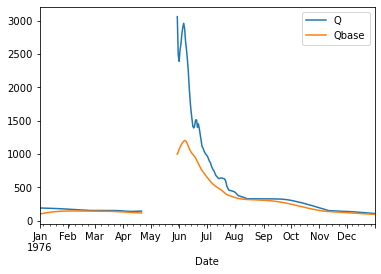

In [33]:
every_gauge_split_by_year[0][19].set_index('Date').plot()

<AxesSubplot:xlabel='Date'>

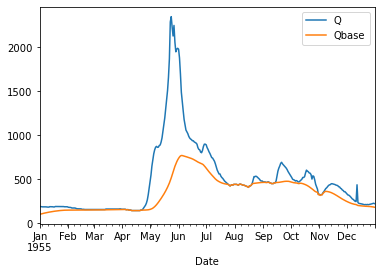

In [34]:
every_gauge_split_by_year[0][0].set_index('Date').plot()

#### BFI without numba support

In [11]:
"Создаём отдельные вектора в соответствии с разбиением на куски без NaN"

###################################################################


def FirstPass(Q, alpha):

    q_f_1 = [[[] for _ in range(len(i))] for i in Q]
    q_b_1 = [[[] for _ in range(len(i))] for i in Q]

    for i in range(len(Q)):           
        """
        Задаём первые величины векторе "быстрого" стока

        """
        q_f_1[i][0] = Q[i][0]

        for j in range(len(Q[i])-1):
            """
            Для каждого куска считаем быстрый сток

            """
            q_f_1[i][j+1] = alpha * q_f_1[i][j] + 0.5 * (1 + alpha) * (Q[i][j+1] - Q[i][j])

        for j in range(len(Q[i])):
            if q_f_1[i][j] < 0:
                q_b_1[i][j] = Q[i][j]
            else:
                q_b_1[i][j] = Q[i][j] - q_f_1[i][j]
    
    Q_forward_1 = [q_f_1, q_b_1]
    
    return q_f_1, q_b_1

###################################################################

def BackwardPass(Q_forward_1, alpha):

    """
    Здесь Q - n-мерный лист в зависимости от числа разбиений
    """

    Qq = Q_forward_1[0]
    Qb = Q_forward_1[1]

    q_f_2 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_2 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):
        "последняя величина предыдущего шага - первая в обратном"
        q_f_2[i][-1] = Qb[i][-1]

        for j in range(len(Qq[i])-2, -1, -1):
            q_f_2[i][j] = alpha * q_f_2[i][j+1] + 0.5 * (1 + alpha) * (Qb[i][j] - Qb[i][j+1])

        for j in reversed(range(len(Qq[i]))):
            if q_f_2[i][j] < 0:
                q_b_2[i][j] = Qb[i][j]
            else:
                q_b_2[i][j] = Qb[i][j] - q_f_2[i][j]
    Q_backward = [q_f_2, q_b_2]

    return Q_backward

###################################################################

def ForwardPass(Q_backward, alpha):

    Qq = Q_backward[0]
    Qb = Q_backward[1]

    q_f_3 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_3 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):

        "Теперь первая величина предыдущего шага - первая и здесь"

        q_f_3[i][0] = Qb[i][0]

        for j in range(len(Qb[i])-1):

            q_f_3[i][j+1] = alpha * q_f_3[i][j] + 0.5 * (1 + alpha) * (Qb[i][j+1] - Qb[i][j])

        for j in range(len(Qb[i])):
            if q_f_3[i][j] < 0:
                q_b_3[i][j] = Qb[i][j]
            else:
                q_b_3[i][j] = Qb[i][j] - q_f_3[i][j]

    Q_forward = [q_f_3, q_b_3]

    return Q_forward

###################################################################

def BFI_calc(Q, alpha, passes, reflect):
    """
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    
    Qin = Q
    
    "отложим отраженные величины с конца и начала нашего ряда"
    Q_reflect = [[[] for _ in range(len(i) + 2 * reflect)] for i in Q]

    for i in range(len(Q_reflect)):

        Q_reflect[i][:reflect] = Q[i][(reflect):0:-1] #добавляем 

        Q_reflect[i][(reflect):(reflect + len(Q[i]))] = Q[i]

        Q_reflect[i][(reflect + len(Q[i])):(len(Q[i]) + 2 + 2 * reflect)] = Q[i][len(Q[i])-2:len(Q[i]) - reflect - 2:-1]
    
    Q1 = FirstPass(Q_reflect, alpha)

    "how many backwards/forward passes to we need © Anthony Ladson"

    n_pass = round(0.5 * (passes -1))

    BackwardPass(Q1, alpha)

    for i in range(n_pass):
        Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

    ################# end of passes  ##############################
    
    Qbase = [i[reflect:(len(i)-reflect)] for i in Q1[1]]
    Qbase = [[0 if j < 0 else j for j in i] for i in Qbase]
    
    # расчёт взвешенного среднего для разбитого на куски ряда расходов
    
    len_Qbase = len([item for sublist in Qbase for item in sublist]) # длина всех расходов, без учёта пропусков
    weights_for_average = [len(i)/len_Qbase for i in Qbase] # вес для среднего по каждому элементу
    
    weighted_bfi = np.sum([weights_for_average[i] * np.nanmean(Qbase[i]/np.nanmean(Qin[i])) if np.nanmean(Qin[i]) != 0 else weights_for_average[i] * 0 for i in range(len(Qbase))]) #взвешенное среднее по выпуклой комбинации

    return weighted_bfi, Qbase

#### hfd_mean
#### mean half-flow date (date on which the cumulative discharge since 1 October reaches half of the annual discharge)

In [149]:
def hfd_mean_for_gauges(Valid_gauges_cms, number_of_NaN):
    from tqdm import trange
    every_gauge_split_by_year_hfd = split_by_year(Valid_gauges_Q_cms, number_of_NaN)
    hfd_date = [[[] for year in gauge] for gauge in every_gauge_split_by_year_hfd]
    for i in range(len(hfd_date)):
        for j in range(len(hfd_date[i])-1):
            if (every_gauge_split_by_year_hfd[i][j].Date[0].year + 1 == every_gauge_split_by_year_hfd[i][j+1].Date[0].year) and ((len(every_gauge_split_by_year_hfd[i][j]) == 365) or (len(every_gauge_split_by_year_hfd[i][j]) == 366)):
                hfd_1_october = pd.concat([every_gauge_split_by_year_hfd[i][j], every_gauge_split_by_year_hfd[i][j+1]]).reset_index(drop = True)
                hfd_date[i][j] = [hfd_1_october, every_gauge_split_by_year_hfd[i][j+1].Q.sum()/2]
            else:
                hfd_date[i][j] = [np.NaN]

    hfd = [[[] for _ in range(len(hfd_date[i]))] for i in range(len(hfd_date))]

    for i in trange(len(hfd_date)):
        for j in range(len(hfd_date[i])):
            half_discharge = 0
            if len(hfd_date[i][j]) != 2:
                hfd[i][j] = [np.NaN]
            else:     
                for k in range(len(hfd_date[i][j][0].Q.to_numpy())):
                    half_discharge += hfd_date[i][j][0].Q.to_numpy()[k + hfd_date[i][j][0].Date[hfd_date[i][j][0].Date == pd.to_datetime(datetime.datetime(hfd_date[i][j][0].Date[0].year, 10, 1))].index[0]]
                    if half_discharge >= hfd_date[i][j][1]:
                        hfd[i][j] = k
                        break

    for i, gauge in enumerate(hfd):
        if len(gauge) == 1:
            hfd[i] = gauge[0]
        else:
            hfd[i] = np.nanmean(gauge)

    return hfd
        

In [150]:
hfd = hfd_mean_for_gauges(Valid_gauges_Q_cms, 0)

100%|██████████| 186/186 [03:46<00:00,  1.22s/it]
/home/dima/miniconda3/envs/geo/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: unsupported operand type(s) for +: 'int' and 'list'

#### Q5
#### 5 % flow quantile (low flow)




In [63]:
def Q5_for_gauge(list_of_gauges):
    Q5 = [np.nanpercentile(gauge.Q.to_numpy(), q = 100 - 5) for gauge in Valid_gauges_Q_mm]
    return Q5
Q5 = Q5_for_gauge(Valid_gauges_Q_mm)

#### Q95
#### 95 % flow quantile (high flow)

In [68]:
def Q95_for_gauge(list_of_gauges):
    Q95 = [np.nanpercentile(gauge.Q.to_numpy(), q = 100 - 95) for gauge in Valid_gauges_Q_mm]
    return Q95
Q95 = Q95_for_gauge(Valid_gauges_Q_mm)

#### high_q_freq
#### frequency of high-flow days (> 9 times the median daily flow)

In [154]:
def high_q_frequency(Valid_gauges_in_mm, number_of_Nan):
    
    every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_Nan)
    
    temp_high_q_f = [[] for _ in every_gauge_split_by_year_mm]
    
    for i, gauge in enumerate(every_gauge_split_by_year_mm):
        for year in gauge:
            if len(gauge) > 1:
                temp_high_q_f[i].append(len(year[year.Q > Valid_gauges_in_mm[i].Q.dropna().median() * 9]))
            else:
                temp_high_q_f[i].append(np.NaN)
                
    high_q_f = list()
    for gauge in temp_high_q_f:
        if len(gauge) > 1:
            high_q_f.append(np.mean(gauge))
        else:
            high_q_f.append(np.NaN)
        
    
    return high_q_f
    

# high_q_f2 = [np.mean([len(year[year.Q > Valid_gauges_Q_mm[i].Q.dropna().median()*9]) for year in gauge]) if len(gauge) > 1 else np.NaN for i, gauge in enumerate(every_gauge_split_by_year_mm)]

In [157]:
high_q_f = high_q_frequency(Valid_gauges_Q_mm, 0)

#### high_q_dur
#### average duration of high-flow events (number of consecutive days > 9 times the median daily flow)

In [280]:
def high_q_duration(Valid_gauges_in_mm, number_of_Nan):
    every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_Nan)
    
    temp_for_high_q_dur = [[[] for _ in every_gauge_split_by_year_mm[i] ] for i in range(len(every_gauge_split_by_year_mm))]
    
    # segments with high events per year
    for i, gauge in enumerate(every_gauge_split_by_year_mm):
        for j, year in enumerate(gauge):
            for values in np.ma.clump_unmasked(np.ma.masked_where(year.Q < Valid_gauges_Q_mm[i].Q.dropna().median()*9, year.Q)):
                temp_for_high_q_dur[i][j].append(year.Q[values])
    
    # number of days per year
    temp_2_for_high_q_dur = [[] for _ in every_gauge_split_by_year_mm]
    for i, gauge in enumerate(temp_for_high_q_dur):
        for year in gauge:
            for split in year:
                temp_2_for_high_q_dur[i].append(len(split))
    
    #average of high flow events per year
    
    high_q_dur = list()
    
    for gauge in temp_2_for_high_q_dur:
        if len(gauge) > 1:
            high_q_dur.append(np.mean(gauge))
        else:
            high_q_dur.append(np.NaN)
    
    return high_q_dur

In [266]:
high_q_dur = high_q_duration(Valid_gauges_Q_mm, 0)

#### low_q_freq
### frequency of low-flow days (< 0.2 times the mean daily flow)

In [171]:
def low_q_frequency(Valid_gauges_in_mm, number_of_Nan):
    
    every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_Nan)
    
    temp_low_q_f = [[] for _ in every_gauge_split_by_year_mm]
    
    for i, gauge in enumerate(every_gauge_split_by_year_mm):
        for year in gauge:
            if len(gauge) > 1:
                temp_low_q_f[i].append(len(year[year.Q < Valid_gauges_in_mm[i].Q.dropna().mean() * 0.2]))
            else:
                temp_low_q_f[i].append(np.NaN)
                
    low_q_f = list()
    for gauge in temp_low_q_f:
        if len(gauge) > 1:
            low_q_f.append(np.mean(gauge))
        else:
            low_q_f.append(np.NaN)
        
    
    return low_q_f

low_q_freq = [np.mean([len(year[year.Q < year.Q.mean()*0.2]) for year in gauge]) if len(gauge) > 2 else np.NaN for gauge in every_gauge_split_by_year_mm]

In [173]:
low_q_f = low_q_frequency(Valid_gauges_Q_mm, 0)

#### low_q_dur
#### average duration of low-flow events (number of consecutive days < 0.2 times the mean daily flow)

In [284]:
def low_q_duration(Valid_gauges_in_mm, number_of_NaN):
    every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_NaN)
    
    temp_for_low_q_dur = [[[] for _ in every_gauge_split_by_year_mm[i] ] for i in range(len(every_gauge_split_by_year_mm))]
    
    # segments with low events per year
    for i, gauge in enumerate(every_gauge_split_by_year_mm):
        for j, year in enumerate(gauge):
            for values in np.ma.clump_unmasked(np.ma.masked_where(year.Q > Valid_gauges_Q_mm[i].Q.dropna().mean()*0.2, year.Q)):
                temp_for_low_q_dur[i][j].append(year.Q[values])
    
    # number of days per year
    temp_2_for_low_q_dur = [[] for _ in every_gauge_split_by_year_mm]
    for i, gauge in enumerate(temp_for_low_q_dur):
        for year in gauge:
            for split in year:
                temp_2_for_low_q_dur[i].append(len(split))
    
    #average of low flow events per year
    
    low_q_dur = list()
    
    for gauge in temp_2_for_low_q_dur:
        if len(gauge) > 1:
            low_q_dur.append(np.mean(gauge))
        else:
            low_q_dur.append(np.NaN)
    
    return low_q_dur

In [282]:
low_q_dur = low_q_duration(Valid_gauges_Q_mm, 0)

#### zero_q_freq
#### frequency of days with Q = 0

In [293]:
def zero_q_frequency(Valid_gauge_in_mm, number_of_NaN):
    every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_NaN)
    
    temp_for_zero_q_freq = [[] for _ in every_gauge_split_by_year_mm]
    
    for i, gauge in enumerate(every_gauge_split_by_year_mm):
        for year in gauge:
            temp_for_zero_q_freq[i].append(sum(year.Q == 0)/len(year.Q))
    
    zero_q_freq = list()
    
    for gauge in temp_for_zero_q_freq:
        if len(gauge) > 1:
            zero_q_freq.append(np.mean(gauge))
        else:
            zero_q_freq.append(np.NaN)
            
    return zero_q_freq

In [296]:
zero_q_freq = zero_q_frequency(Valid_gauges_Q_mm, 0)

In [153]:
def from_grdc_to_hydro_camels(path, path_to_results):
    
    ###########################################################################################################################################
    
    def read_data(path):
        all_files = glob.glob(path + '/*_Q_Day.Cmd.txt')
        list_of_gauges = list()
        list_of_station_IDS = [i[74:81] for i in all_files] # лист всех ID из представленных постов
        valid_IDS = list()
        for i, gauge in enumerate(all_files):

            """
            skip instance if it's empty

            """
            test = pd.read_csv(gauge, skiprows = 36, delimiter = ';', skipinitialspace = True)

            if test.empty:
                pass

            else:
                """
                read data; 
                change default column names;
                replace -999 with NaN;
                drop unnecessary column;
                add column with baseflow calculated with BFI function
                add it to list of valid time serieses 

                """
                test.Value = test.Value.replace(-999, np.NaN)
                test['YYYY-MM-DD'] = pd.to_datetime(test['YYYY-MM-DD'])
                test = test.drop(columns = ['hh:mm'])
                test.rename(columns = {'YYYY-MM-DD': 'Date', 'Value': 'Q'}, inplace = True)
                test['Qbase'] = np.NaN
                list_of_gauges.append(test)
                valid_IDS.append(int(list_of_station_IDS[i]))
        print('количество постов с убранными пустышками {}, всего постов с суточными данными {}'.format(len(list_of_gauges), len(all_files)))
        return valid_IDS, list_of_gauges


    valid_IDS, list_of_gauges = read_data(path)
    
    ###########################################################################################################################################
    
    def get_WS_info(path, valid_IDS):
        import geojson as gjs
        with open(path + '/stationbasins.geojson') as f:
            WS_info = gjs.load(f)

        WS_info = [i['attributes'] for i in WS_info['features']]

        Valid_WS_Info = [WS_info[i] for i in range(len(WS_info)) if WS_info[i]['grdc_no'] in valid_IDS]

        Valid_WS = pd.DataFrame(columns = {'ID', 'River_Name', 'WS_area'}) # dataframe for WS data
        Valid_WS.ID = valid_IDS # assign only valuable WS with daily discharge available

        temp_list_for_AREA = [[] for _ in range(len(Valid_WS.ID))] # empty list to store river name
        # list of lists is used as a solution to solve .loc copy problem from df
        temp_list_for_RIVER_NAME = [[] for _ in range(len(Valid_WS.ID))]

        for j in range(len(Valid_WS.ID)):
            for i in range(len(Valid_WS_Info)):
                fnd = True
                while fnd:

                    fnd = False

                    if Valid_WS.ID.loc[j] == Valid_WS_Info[i]['grdc_no']:
                        temp_list_for_AREA[j].append(Valid_WS_Info[i]['area_hys'])
                        temp_list_for_RIVER_NAME[j].append(Valid_WS_Info[i]['river'] + ' - ' + Valid_WS_Info[i]['station'])

                        fnd = True
                        break

        temp_list_for_AREA = [np.NaN if len(i) == 0 else i[0] for i in temp_list_for_AREA]
        temp_list_for_RIVER_NAME = [np.NaN if len(i) == 0 else i[0] for i in temp_list_for_RIVER_NAME]

        """
        Датасет сформирован таким образом, что здесь используются только те посты, 
        по которым есть данные суточного стока
        Расположены они в том же порядке, что и данные по расходам в
        переменной

        Далее, обращаясь к ID, получаем данные по площади водосбора,
        которые используются дальше, при получении миллиметров слоя

        """

        Valid_WS.River_Name = temp_list_for_RIVER_NAME
        Valid_WS.WS_area = temp_list_for_AREA
        Valid_WS = Valid_WS[[Valid_WS.columns.tolist()[1], Valid_WS.columns.tolist()[2], Valid_WS.columns.tolist()[0]]]

        return Valid_WS


    Valid_WS = get_WS_info(path, valid_IDS)
    
    ###########################################################################################################################################
    
    def get_WS_w_Area(Valid_WS):
        """
        Дальнейший расчёт будет вестись только для тех постов,
        у которых есть данные о площади

        """
        Valid_WS = Valid_WS.dropna().reset_index(drop = True)
        Valid_gauges_Q_cms = [gauge for i, gauge in enumerate(list_of_gauges) if valid_IDS[i] in Valid_WS.ID.to_numpy()]

        import copy

        Valid_gauges_Q_mm = copy.deepcopy(Valid_gauges_Q_cms)

        """
        calculate layer of discharge

        """

        for i, gauge in enumerate(Valid_gauges_Q_mm):
            gauge.Q = 86400 * gauge.Q * 10**9 / (Valid_WS.WS_area.loc[i] * 10**12)
        print('количество постов с данными и площадью {}, всего постов с суточными данными {}'.format(len(Valid_gauges_Q_mm), len(valid_IDS)))
        return Valid_gauges_Q_mm, Valid_gauges_Q_cms


        Valid_gauges_Q_mm, Valid_gauges_Q_cms = get_WS_w_Area(Valid_WS)
    
    ###########################################################################################################################################
    
    def split_by_year(list_of_something, number_of_NaN):
    
        """
        Данная функция разбивает лист датафреймов по годам
        и выкидывает года, где NaN регулируется переменной number_of_NaN

        Колонка Date в датафрейме внутри листа - даты
        и она обязательна. 
        Столбцы могут называться в соответствии с пожеланиями

        """
        splitted_list = list()

        for i, gauge in enumerate(list_of_something):
            """
            From list of lists we are calling another list 
            that consist list of dataframes

            """
            year_split = list()
            unique_years = gauge.Date.dt.year.unique()

            for year in unique_years:
                year_split.append(gauge[gauge.Date.dt.year == year].reset_index(drop = True))

            for i in range(len(year_split)-1, -1, -1):
                if sum(year_split[i].Q.isna()) > number_of_NaN:
                    del year_split[i]
                else:
                    pass

            splitted_list.append(year_split)

        return splitted_list

    ###########################################################################################################################################
    
    """
    Q mean for observations on every valid gauge. Dimension - mm/day

    """

    def mean_for_gauge(list_of_gauges):
        gauges_Q_mean = [np.nanmean(i.Q) for i in list_of_gauges]
        return gauges_Q_mean
    
    ###########################################################################################################################################
    
    def slope_fdc_gauge(list_of_gauges):
        slope_fdc = []
        for i, gauge in enumerate(list_of_gauges):
            if (np.nanpercentile(gauge.Q.to_numpy(), q = 100-33) > 0) & (np.nanpercentile(gauge.Q.to_numpy(), q = 100 - 66) > 0):
                slope_fdc.append((math.log(np.nanpercentile(gauge.Q.to_numpy(), q = 100-33)) - math.log(np.nanpercentile(gauge.Q.to_numpy(), q = 100-66)))/(0.66-0.33))
            else:
                slope_fdc.append(np.NaN)
        return slope_fdc
    
    ###########################################################################################################################################
    
    
    import numba

    """
    Расчёт ведётся для листа в котором нет пропусков. 
    В случае их наличия в общем ряду, он разбивается
    на n-рядов в зависимости от разбиений

    Расчёт BFI далее будет производиться для отдельно 
    взятого года наблюдений

    """
    ###################################################################

    """
    First pass

    """
    @numba.jit(nopython = True)
    def FirstPass(Q, alpha):

        q_f_1 = [np.float64(np.NaN) for i in Q]
        q_b_1 = [np.float64(np.NaN) for i in Q]

        q_f_1[0] = Q[0]

        for j in range(len(Q)-1):
            """
            for every split calculate quick flow

            """
            q_f_1[j+1] = alpha * q_f_1[j] + 0.5 * (1 + alpha) * (Q[j+1] - Q[j])

        for j in range(len(Q)):
            if q_f_1[j] < 0:
                q_b_1[j] = Q[j]
            else:
                q_b_1[j] = Q[j] - q_f_1[j]

        Q_forward_1 = [q_f_1, q_b_1]

        return Q_forward_1

    ###################################################################
    """
    Backward pass

    """
    @numba.jit(nopython = True)
    def BackwardPass(Q_forward_1, alpha):

        """
        Здесь Q - n-мерный лист в зависимости от числа разбиений
        """

        Qq = Q_forward_1[0]
        Qb = Q_forward_1[1]

        q_f_2 = [np.float64(np.NaN) for i in Qq]
        q_b_2 = [np.float64(np.NaN) for i in Qb]


        "last value of forward step - first in backward step"

        q_f_2[-1] = Qb[-1]

        for j in range(len(Qq)-2, -1, -1):
            q_f_2[j] = alpha * q_f_2[j+1] + 0.5 * (1 + alpha) * (Qb[j] - Qb[j+1])

        for j in range(len(Qq)-1, -1, -1):
            if q_f_2[j] < 0:
                q_b_2[j] = Qb[j]
            else:
                q_b_2[j] = Qb[j] - q_f_2[j]

        Q_backward = [q_f_2, q_b_2]

        return Q_backward

    ###################################################################
    """
    Forward pass

    """
    @numba.jit(nopython = True)
    def ForwardPass(Q_backward, alpha):

        Qq = Q_backward[0]
        Qb = Q_backward[1]

        q_f_3 = [np.float64(np.NaN) for i in Qq]
        q_b_3 = [np.float64(np.NaN) for i in Qb]


        "Теперь первая величина предыдущего шага - первая и здесь"

        q_f_3[0] = Qb[0]

        for j in range(len(Qb)-1):

            q_f_3[j+1] = alpha * q_f_3[j] + 0.5 * (1 + alpha) * (Qb[j+1] - Qb[j])

        for j in range(len(Qb)):
            if q_f_3[j] < 0:
                q_b_3[j] = Qb[j]
            else:
                q_b_3[j] = Qb[j] - q_f_3[j]

        Q_forward = [q_f_3, q_b_3]

        return Q_forward

    ###################################################################
    """
    BFI calculations for given alpha

    """
    @numba.jit(nopython = True)
    def BFI_calc(Q, alpha, passes, reflect):
        """
        we reflect the first reflect values and the last reflect values.  
        this is to get rid of 'warm up' problems © Anthony Ladson
        """ 
        Qin = Q

        "reflect our lists"

        if len(Q)-1 > reflect:
            Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

            Q_reflect[:reflect] = Q[(reflect):0:-1]
            Q_reflect[(reflect):(reflect + len(Q))] = Q
            Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]

        else:        
            Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
            Q_reflect = Q

        Q1 = FirstPass(Q_reflect, alpha)

        "how many backwards/forward passes to we need © Anthony Ladson"

        n_pass = round(0.5 * (passes -1))

        BackwardPass(Q1, alpha)

        for i in range(n_pass):
            Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

        ################# end of passes  ##############################
        if len(Q)-1 > reflect:
            Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
            Qbase = [0 if j < 0 else j for j in Qbase]
        else:
            Qbase = Q1[1]
            Qbase = [0 if j < 0 else j for j in Qbase]

        bfi = 0
        mean_for_period = 0

        if np.mean(Qin) == 0:
            bfi = 0
        else:
            for j in Qbase:
                mean_for_period += j/np.mean(Qin)
            bfi = mean_for_period/len(Qbase)

        return bfi, Qbase

    """
    BFI calculations for 1000 alpha between 0.9 and 0.98

    """

    import random
    @numba.jit(nopython = True)
    def BFI_calc_1000(Q, passes, reflect):
        """
        Расчёт проводится для 1000 случайных значений alpha
        в диапазоне он 0.9 до 0.98

        we reflect the first reflect values and the last reflect values.  
        this is to get rid of 'warm up' problems © Anthony Ladson
        """ 

        random.seed(1996)
        alpha_coefficients = [np.float64(random.uniform(0.9, 0.98)) for i in range(1000)]

        Q = np.array([np.float64(i) for i in Q], dtype = np.float64)
        Qin = Q

        "reflect our lists"

        if len(Q)-1 > reflect:
            Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

            Q_reflect[:reflect] = Q[(reflect):0:-1]
            Q_reflect[(reflect):(reflect + len(Q))] = Q
            Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]

        else:        
            Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
            Q_reflect = Q

        bfi_record = []
        Qbase_record = []

        for i, alpha in enumerate(alpha_coefficients):

            Q1 = FirstPass(Q_reflect, alpha)

            "how many backwards/forward passes to we need © Anthony Ladson"

            n_pass = round(0.5 * (passes -1))

            BackwardPass(Q1, alpha)

            for i in range(n_pass):
                Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)


            ################# end of passes  ##############################
            if len(Q)-1 > reflect:
                Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
                Qbase = [0 if j < 0 else j for j in Qbase]
            else:
                Qbase = Q1[1]
                Qbase = [0 if j < 0 else j for j in Qbase]

            Qbase_record.append(np.array(Qbase, dtype=np.float64))

            bfi = 0
            mean_for_period = 0

            if np.mean(Qin) == 0:
                bfi = 0
            else:
                for j in Qbase:
                    mean_for_period += j/np.mean(Qin)
                bfi = mean_for_period/len(Qbase)

            bfi_record.append(np.float64(bfi))

        """
        After 1000 calculations function return
        mean value out of 1000

        And "mean" hygrograph of baseflow

        """

        # mean BFI out of 1000

        bfi_mean = 0
        for i in bfi_record:
            bfi_mean += i
        bfi_mean = bfi_mean/len(bfi_record)

        # mean hydrograph out of 1000 calculations

        Qbase_mean = [np.float64(0) for i in range(len(Qbase))]

        for Qbase_temp in Qbase_record:
            for i, value in enumerate(Qbase_temp):
                Qbase_mean[i] += value

        Qbase_mean = [np.float64(i/len(Qbase_record)) for i in Qbase_mean]

        return bfi_mean, Qbase_mean
    
    
    ###########################################################################################################################################
    
    def clump_array(a):

        """
        Разбить период наблюдений на куски, в которых нет NaN
        """

        return [np.float64(a[s]) for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]
    
    ###########################################################################################################################################
    
    
    def BFI_calculation_for_lists(Valid_gauges_Q_cms, Number_of_NaN):
        # 
        every_gauge_split_by_year = split_by_year(Valid_gauges_Q_cms, Number_of_NaN)
        # разбитие столбца из датафрейма на промежутки без NaN
        every_gauge_split_by_year_np = [[clump_array(year.Q.to_numpy()) for year in gauge] for gauge in every_gauge_split_by_year]

        clump_bfi = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]
        weights_of_clump = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]
        clump_Qbase = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]

        for i, gauge in enumerate(every_gauge_split_by_year_np):
            start = time.time()
            for j, year in enumerate(gauge):
                for k, clump in enumerate(year):
                    # проверка, что кусок между NaN больше, длины сравнения
                    if type(clump) == np.ndarray:
                        clump_bfi[i][j][k] = BFI_calc_1000(clump, 3, 30)[0]
                        weights_of_clump[i][j][k] = len(clump)/len(every_gauge_split_by_year[i][j].Q)
                        clump_Qbase[i][j][k] = BFI_calc_1000(clump, 3, 30)[1]
                    else:
                        clump_bfi[i][j][k] = np.NaN
                        weights_of_clump[i][j][k] = np.NaN
                        clump_Qbase[i][j][k] = [np.NaN]
            stop = time.time()
            print('итерация {} закончилась за {} секунд'.format(i, round(stop - start)))
        weighted_bfi = [np.mean([np.sum([bfi * weights_of_clump[i][j][k] for k, bfi in enumerate(year)]) for j, year in enumerate(gauge)]) if len(gauge) > 1 else np.NaN for i, gauge in enumerate(clump_bfi)]


        """
           Заполнение столбца Qbase восстанавливая разбитые на куски без NaN наблюдения за стоком
        """

        from itertools import groupby
        def bfi_recover(year_of_observation, bfi_values):

            """
            Восстановления ряда baseflow с учётом ранее "выбитых" пропусков
            """
            Qbase_full = [list(group) for key, group in groupby(year_of_observation.Q.to_numpy(), key=np.isnan)] # разбитие на группы по признаку. Получается n листов. NaN и !NaN разбиты по листам
            mask_to_refill = [~np.isnan(i).any() for i in Qbase_full] # индексируем их как одинокие булевые величины

            position_index = -1
            for j, mask in enumerate(mask_to_refill):
                """
                Так как первичный разрезанный лист из функции clumped_array имеет в себе количество листов, такое же как и True, то восстанавливаем в соответствии

                Аргумент position_index подбирается в соответствии с присутсвием с True и адресуется к нужному куску в Qbase

                Всё перезаписывается в лист, где в перезаписываемых значениях эквивалентные по длине значения стока
                """
                if len(Qbase_full) > 1:
                    if mask:
                        position_index += 1
                        Qbase_full[j] = bfi_values[position_index]
                    else:
                        position_index = position_index
                        Qbase_full[j] = Qbase_full[j]
                else:
                    Qbase_full[j] = [item for sublist in bfi_values for item in sublist]

            if len(Qbase_full) > 1:
                Qbase_full = [item for sublist in Qbase_full for item in sublist] # лист листов в лист с учётом NaN
            else:
                Qbase_full = [item for sublist in Qbase_full for item in sublist]

            return Qbase_full

        for i, gauge in enumerate(every_gauge_split_by_year_np):
            for j, year in enumerate(gauge):
                for k, clump in enumerate(year):
                    every_gauge_split_by_year[i][j].Qbase = bfi_recover(every_gauge_split_by_year[i][j], clump_Qbase[i][j])

        return weighted_bfi, every_gauge_split_by_year
    
    
    ###########################################################################################################################################
    
    
    def hfd_mean_for_gauges(Valid_gauges_cms, number_of_NaN):
        from tqdm import trange
        every_gauge_split_by_year_hfd = split_by_year(Valid_gauges_Q_cms, number_of_NaN)
        hfd_date = [[[] for year in gauge] for gauge in every_gauge_split_by_year_hfd]
        for i in range(len(hfd_date)):
            for j in range(len(hfd_date[i])-1):
                if (every_gauge_split_by_year_hfd[i][j].Date[0].year + 1 == every_gauge_split_by_year_hfd[i][j+1].Date[0].year) and ((len(every_gauge_split_by_year_hfd[i][j]) == 365) or (len(every_gauge_split_by_year_hfd[i][j]) == 366)):
                    hfd_1_october = pd.concat([every_gauge_split_by_year_hfd[i][j], every_gauge_split_by_year_hfd[i][j+1]]).reset_index(drop = True)
                    hfd_date[i][j] = [hfd_1_october, every_gauge_split_by_year_hfd[i][j+1].Q.sum()/2]
                else:
                    hfd_date[i][j] = [np.NaN]

        hfd = [[[] for _ in range(len(hfd_date[i]))] for i in range(len(hfd_date))]

        for i in trange(len(hfd_date)):
            for j in range(len(hfd_date[i])):
                half_discharge = 0
                if len(hfd_date[i][j]) != 2:
                    hfd[i][j] = [np.NaN]
                else:     
                    for k in range(len(hfd_date[i][j][0].Q.to_numpy())):
                        half_discharge += hfd_date[i][j][0].Q.to_numpy()[k + hfd_date[i][j][0].Date[hfd_date[i][j][0].Date == pd.to_datetime(datetime.datetime(hfd_date[i][j][0].Date[0].year, 10, 1))].index[0]]
                        if half_discharge >= hfd_date[i][j][1]:
                            hfd[i][j] = k
                            break

        for i, gauge in enumerate(hfd):
            if len(gauge) == 1:
                hfd[i] = gauge[0]
            else:
                hfd[i] = np.nanmean(gauge)

        return hfd
        
    
    
    ###########################################################################################################################################
    
    
    def Q5_for_gauge(list_of_gauges):
        Q5 = [np.nanpercentile(gauge.Q.to_numpy(), q = 100 - 5) for gauge in Valid_gauges_Q_mm]
        return Q5
    
    
    ###########################################################################################################################################
    
    
    def Q95_for_gauge(list_of_gauges):
        Q95 = [np.nanpercentile(gauge.Q.to_numpy(), q = 100 - 95) for gauge in Valid_gauges_Q_mm]
        return Q95
    
    
    ###########################################################################################################################################
    
    
    def high_q_frequency(Valid_gauges_in_mm, number_of_Nan):
    
        every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_Nan)

        temp_high_q_f = [[] for _ in every_gauge_split_by_year_mm]

        for i, gauge in enumerate(every_gauge_split_by_year_mm):
            for year in gauge:
                if len(gauge) > 1:
                    temp_high_q_f[i].append(len(year[year.Q > Valid_gauges_in_mm[i].Q.dropna().median() * 9]))
                else:
                    temp_high_q_f[i].append(np.NaN)

        high_q_f = list()
        for gauge in temp_high_q_f:
            if len(gauge) > 1:
                high_q_f.append(np.mean(gauge))
            else:
                high_q_f.append(np.NaN)


        return high_q_f
    
    
    ###########################################################################################################################################
    
    
    def high_q_duration(Valid_gauges_in_mm, number_of_Nan):
        every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_Nan)

        temp_for_high_q_dur = [[[] for _ in every_gauge_split_by_year_mm[i] ] for i in range(len(every_gauge_split_by_year_mm))]

        # segments with high events per year
        for i, gauge in enumerate(every_gauge_split_by_year_mm):
            for j, year in enumerate(gauge):
                for values in np.ma.clump_unmasked(np.ma.masked_where(year.Q < Valid_gauges_Q_mm[i].Q.dropna().median()*9, year.Q)):
                    temp_for_high_q_dur[i][j].append(year.Q[values])

        # number of days per year
        temp_2_for_high_q_dur = [[] for _ in every_gauge_split_by_year_mm]
        for i, gauge in enumerate(temp_for_high_q_dur):
            for year in gauge:
                for split in year:
                    temp_2_for_high_q_dur[i].append(len(split))

        #average of high flow events per year

        high_q_dur = list()

        for gauge in temp_2_for_high_q_dur:
            if len(gauge) > 1:
                high_q_dur.append(np.mean(gauge))
            else:
                high_q_dur.append(np.NaN)

        return high_q_dur

    
    
    ###########################################################################################################################################
    
    
    def low_q_frequency(Valid_gauges_in_mm, number_of_Nan):
    
        every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_Nan)

        temp_low_q_f = [[] for _ in every_gauge_split_by_year_mm]

        for i, gauge in enumerate(every_gauge_split_by_year_mm):
            for year in gauge:
                if len(gauge) > 1:
                    temp_low_q_f[i].append(len(year[year.Q < Valid_gauges_in_mm[i].Q.dropna().mean() * 0.2]))
                else:
                    temp_low_q_f[i].append(np.NaN)

        low_q_f = list()
        for gauge in temp_low_q_f:
            if len(gauge) > 1:
                low_q_f.append(np.mean(gauge))
            else:
                low_q_f.append(np.NaN)


        return low_q_f
    
    
    ###########################################################################################################################################
    
    
    def low_q_duration(Valid_gauges_in_mm, number_of_NaN):
        every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_NaN)

        temp_for_low_q_dur = [[[] for _ in every_gauge_split_by_year_mm[i] ] for i in range(len(every_gauge_split_by_year_mm))]

        # segments with low events per year
        for i, gauge in enumerate(every_gauge_split_by_year_mm):
            for j, year in enumerate(gauge):
                for values in np.ma.clump_unmasked(np.ma.masked_where(year.Q > Valid_gauges_Q_mm[i].Q.dropna().mean()*0.2, year.Q)):
                    temp_for_low_q_dur[i][j].append(year.Q[values])

        # number of days per year
        temp_2_for_low_q_dur = [[] for _ in every_gauge_split_by_year_mm]
        for i, gauge in enumerate(temp_for_low_q_dur):
            for year in gauge:
                for split in year:
                    temp_2_for_low_q_dur[i].append(len(split))

        #average of low flow events per year

        low_q_dur = list()

        for gauge in temp_2_for_low_q_dur:
            if len(gauge) > 1:
                low_q_dur.append(np.mean(gauge))
            else:
                low_q_dur.append(np.NaN)

        return low_q_dur

    
    
    ###########################################################################################################################################
    
    
    def zero_q_frequency(Valid_gauge_in_mm, number_of_NaN):
        every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, number_of_NaN)

        temp_for_zero_q_freq = [[] for _ in every_gauge_split_by_year_mm]

        for i, gauge in enumerate(every_gauge_split_by_year_mm):
            for year in gauge:
                temp_for_zero_q_freq[i].append(sum(year.Q == 0)/len(year.Q))

        zero_q_freq = list()

        for gauge in temp_for_zero_q_freq:
            if len(gauge) > 1:
                zero_q_freq.append(np.mean(gauge))
            else:
                zero_q_freq.append(np.NaN)

        return zero_q_freq    
    
    ###########################################################################################################################################

    camels_ru_hydro = pd.DataFrame(data = [Valid_WS.ID.to_numpy(), 
                                           mean_for_gauge(Valid_gauges_Q_mm),
                                           slope_fdc_gauge(Valid_gauges_Q_mm),
                                           BFI_calculation_for_lists(Valid_gauges_Q_cms, 60)[0],
                                           hfd_mean_for_gauges(Valid_gauges_Q_cms, 0), 
                                           Q5_for_gauge(Valid_gauges_Q_mm), 
                                           Q95_for_gauge(Valid_gauges_Q_mm),
                                           high_q_frequency(Valid_gauges_Q_mm, 0),
                                           high_q_duration(Valid_gauges_Q_mm, 0),
                                           low_q_frequency(Valid_gauges_Q_mm, 0),
                                           low_q_duration(Valid_gauges_Q_mm, 0),
                                           zero_q_frequency(Valid_gauges_Q_mm, 0)])
    camels_ru_hydro = camels_ru_hydro.T
    camels_ru_hydro.columns = ['ID', 'Q_mean', 'slope_hfd', 'bfi', 'hfd_mean', 'Q5', 'Q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq']
    camels_ru_hydro = camels_ru_hydro.applymap('{:.2f}'.format)
    camels_ru_hydro.ID = Valid_WS.ID.to_numpy()
    camels_ru_hydro.to_csv(path_to_results + 'camels_ru_hydro.csv', sep = ';', index = False)
    
    return camels_ru_hydro